### Цель ноутбука

Реализовать операцию свёртки двух матриц и научиться использовать матричные фильтры с помощью собственной функции и функций библиотеки OpenCV.

### 1. Устанавливаем и импортируем необходимые библиотеки

In [ ]:
!pip install opencv-python
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 2. Пишем функцию свёртки

Напишем функцию свёртки двух матриц. Для простоты будем работать с одноканальными чёрно-белыми изображениями и считать, что ядро свёртки имеет размер $s\times s$, где $s$ — нечётное число. Важно иметь в виду, что результат свёртки матрицы с ядром будет иметь меньший размер, чем исходная матрица.

In [ ]:
def convolve(mat, kernel):
    '''
    mat: h * w
    kernel: s * s (s = 2k + 1)
    res: (h - s + 1) * (w - s + 1)
    '''

    # создаём матрицу для хранения результата меньшего размера
    res_size = list(mat.shape)
    s = kernel.shape[0]
    res_size[0] -= s - 1
    res_size[1] -= s - 1
    res = np.zeros(res_size)

    # вычисляем каждый элемент матрицы результата
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i, j] = (mat[i:i+s, j:j+s] * kernel).sum()

    res = np.clip(res, 0, 255)

    return res

### 3. Загружаем изображение в ч/б

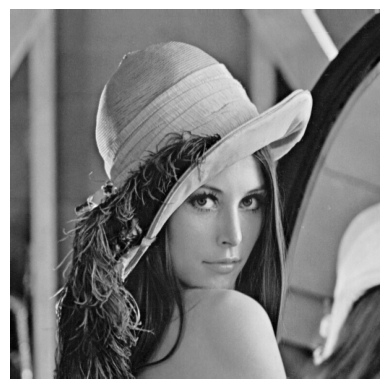

In [ ]:
img_gray = cv2.imread('Lenna.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

### 4. Фильтр сглаживания

Фильтр усреднения — это свёртка с ядром вида:

$$kernel = \frac{1}{s^2} \begin{pmatrix}
    1 & 1 & \dots & 1\\
    1 & 1 & \dots & 1\\
    \vdots & \vdots & \ddots & \vdots\\
    1 & 1 & \dots & 1
\end{pmatrix}.$$

Чем больше размер ядра, тем сильнее происходит усреднение пикселей.

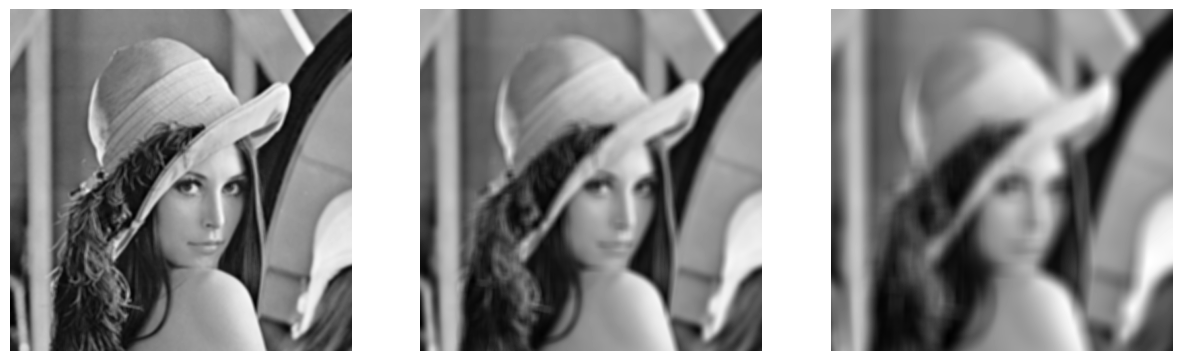

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, s in enumerate([5, 11, 23]):
    axs[i].imshow(convolve(img_gray, np.ones((s, s)) / s ** 2), cmap='gray')
    axs[i].axis('off')

plt.show()

### 5. Гауссовский фильтр сглаживания

Ядро гауссовского фильтра определяется формулой:
$$G(x, y) = \frac{1}{2\pi\sigma}\exp(-\frac{x^2 + y^2}{2\sigma^2}).$$

Посмотрим на примеры таких ядер.

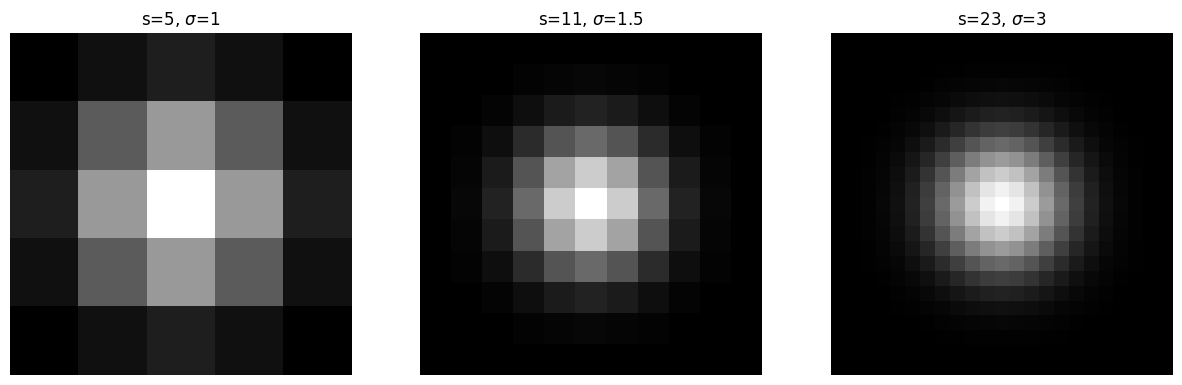

In [ ]:
def gaussian_kernel(s, sigma=1):
    k = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            k[i, j] = np.exp(-((i - s // 2) ** 2 + (j - s // 2) ** 2) / (2 * sigma ** 2))
    k /= 2 * np.pi * sigma
    k /= k.sum()
    return k

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (s, sigma) in enumerate(zip([5, 11, 23], [1, 1.5, 3])):
    kernel = gaussian_kernel(s, sigma)
    axs[i].imshow(kernel, cmap='gray')
    axs[i].set_title(f's={s}, $\sigma$={sigma}')
    axs[i].axis('off')

plt.show()

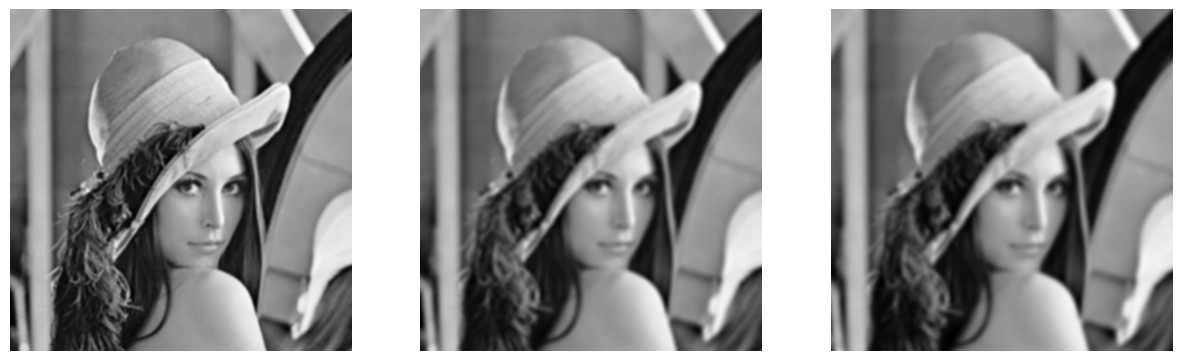

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, s in enumerate([5, 11, 23]):
    axs[i].imshow(convolve(img_gray, gaussian_kernel(s, sigma=3)), cmap='gray')
    axs[i].axis('off')

plt.show()

### 6. Фильтр увеличения резкости

В двух предыдущих фильтрах мы уменьшали различия между соседними пикселями, тем самым сглаживая изображение. Но с помощью свёртки можно эти различия и увеличить. Например, использовать свёртку со следующим ядром:

$$kernel = \begin{pmatrix}
    -1 & -1 & -1\\
    -1 & 9 & -1\\
    -1 & -1 & -1
\end{pmatrix}$$

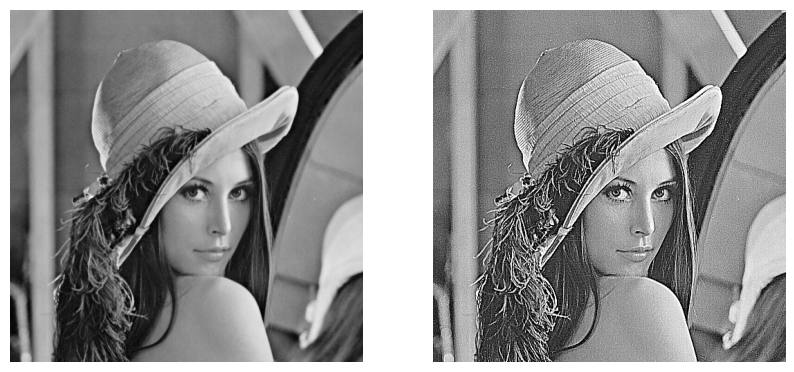

In [ ]:
k = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_gray, cmap='gray')
axs[0].axis('off')

axs[1].imshow(convolve(img_gray, k), cmap='gray')
axs[1].axis('off')

plt.show()

### 7. Границы Собеля

С помощью матричных фильтров можно даже выделить границы объектов на изображении. Границы чаще всего находятся в тех местах, где происходит резкое изменение цвета между соседними пикселями. Именно на этой идее и построен способ выявления границ Собеля с помощью градиентов.

Используются два ядра, чтобы вычислить градиенты по горизонтали ($G_x$) и вертикали ($G_y$):

$$kernel_x = \begin{pmatrix}
    -1 & 0 & 1\\
    -2 & 0 & 2\\
    -1 & 0 & 1
\end{pmatrix},$$

$$kernel_y = \begin{pmatrix}
    1 & 2 & 1\\
    0 & 0 & 0\\
    -1 & -2 & -1
\end{pmatrix}.$$

Далее они складываются по формуле:

$$G = \sqrt{G_x^2 + G_y^2}.$$

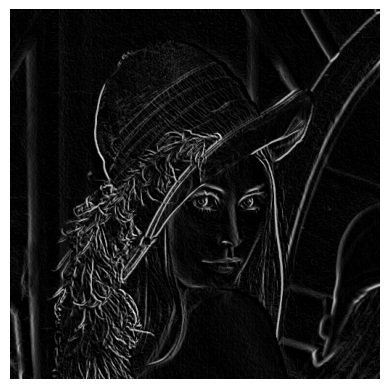

In [ ]:
k_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])
k_y = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]
])

G_x = convolve(img_gray, k_x)
G_y = convolve(img_gray, k_y)

G = np.sqrt(G_x ** 2 + G_y ** 2)

plt.imshow(G, cmap='gray')
plt.axis('off')
plt.show()

### 8. Фильтры в OpenCV

В библиотеке OpenCV реализованы все рассмотренные нами фильтры и многие другие. Наша функция работает правильно, но не очень эффективно и только для одноканальных изображений. Пожалуйста, используйте библиотечные функции в своих программах. Посмотрим, как работают некоторые из них, на примере цветного изображения.

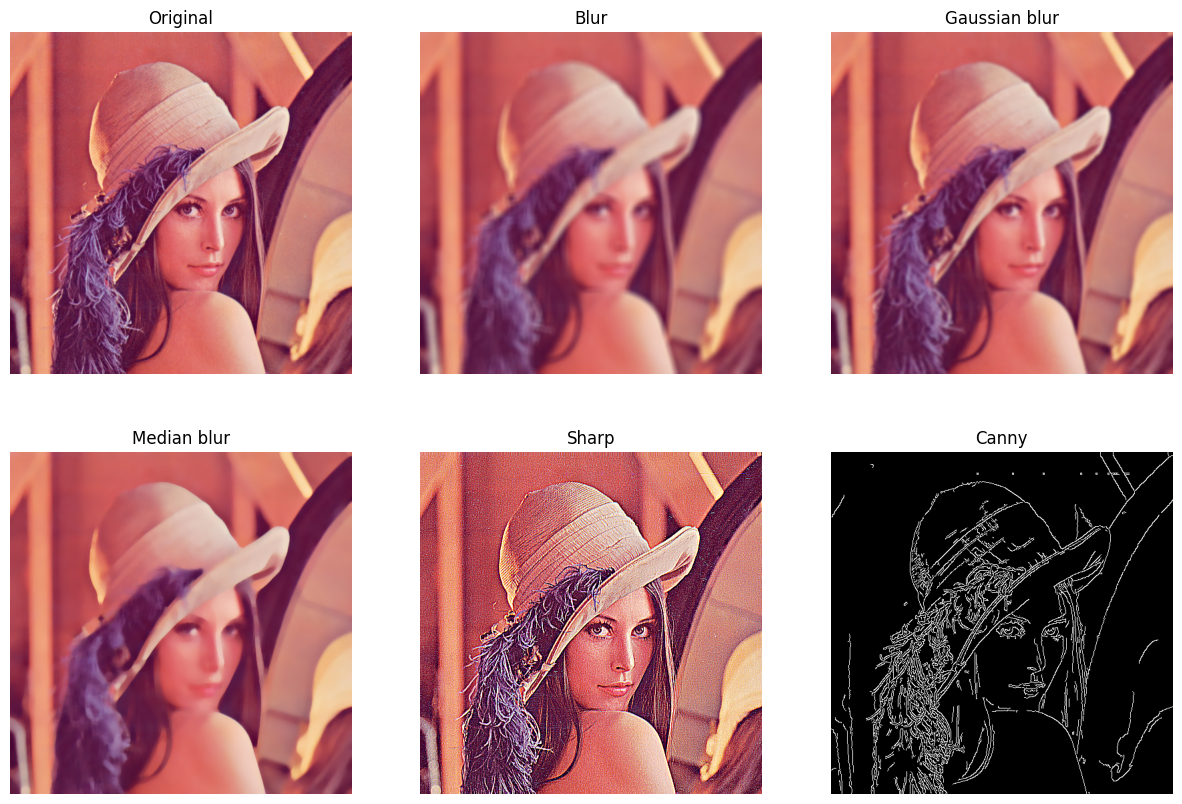

In [ ]:
img = cv2.imread('Lenna.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0,0].imshow(img)
axs[0,0].axis('off')
axs[0,0].set_title('Original')

img_blur = cv2.blur(img, (11, 11))
axs[0,1].imshow(img_blur)
axs[0,1].axis('off')
axs[0,1].set_title('Blur')

img_gauss = cv2.GaussianBlur(img, (11, 11), 0)
axs[0,2].imshow(img_gauss)
axs[0,2].axis('off')
axs[0,2].set_title('Gaussian blur')

img_median = cv2.medianBlur(img, 11)
axs[1,0].imshow(img_median)
axs[1,0].axis('off')
axs[1,0].set_title('Median blur')

k = np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
])
img_sharp = cv2.filter2D(img, -1, k)
axs[1,1].imshow(img_sharp)
axs[1,1].axis('off')
axs[1,1].set_title('Sharp')

img_canny = cv2.Canny(img, 100, 200)
axs[1,2].imshow(img_canny, cmap='gray')
axs[1,2].axis('off')
axs[1,2].set_title('Canny')

plt.show()

### 9. Удаление шума медианным фильтром

У фильтров много разных применений. Выявление границ необходимо для выделения объектов на изображении, анализа их форм, количества и размера. Различное сглаживание убирает лишний шум с изображений, что бывает полезно перед отправкой изображения в модель.

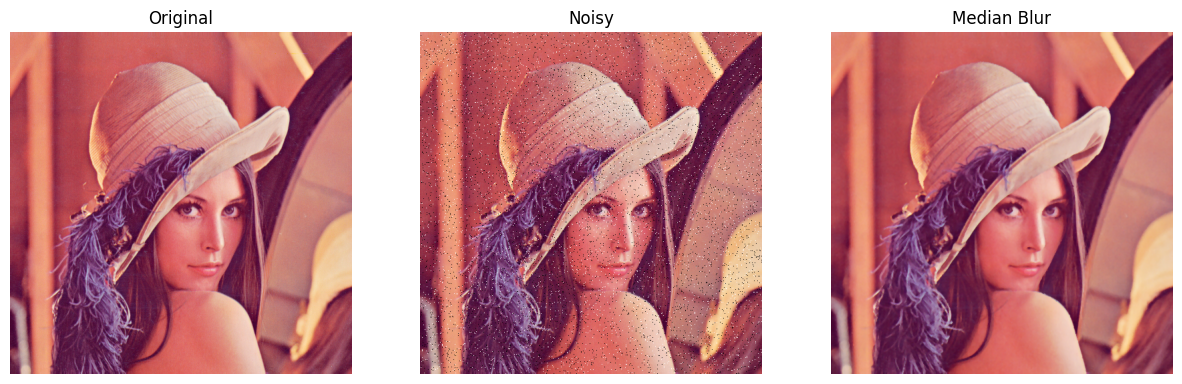

In [ ]:
import random

def add_salt_and_pepper_noise(img):

    h, w, _ = img.shape
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):

        y = random.randint(0, h - 1)
        x = random.randint(0, w - 1)
        img[y][x] = [255, 255, 255]

    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):

        y = random.randint(0, h - 1)
        x = random.randint(0, w - 1)
        img[y][x] = [0, 0, 0]

    return img

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original')

img_noisy = add_salt_and_pepper_noise(img)
axs[1].imshow(img_noisy)
axs[1].axis('off')
axs[1].set_title('Noisy')

img_median = cv2.medianBlur(img_noisy, 3)
axs[2].imshow(img_median)
axs[2].axis('off')
axs[2].set_title('Median Blur')

plt.show()